In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors, ensemble, kernel_ridge, svm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn import neighbors, ensemble, kernel_ridge, svm

## Load data

In [32]:
# Ignore ORIGIN_CALL and other categorical columns
np.random.seed(42)
# train_arr = np.loadtxt("../data/numeric_trainvf.csv", dtype=np.float32, delimiter=",", skiprows=1)[:, 4:]
df_train = pd.read_csv("../data/combined_trainvf_trig.csv", index_col=0)
df_train.head()

# Prune
mean = df_train["TARGET"].mean()
std = df_train["TARGET"].std()
df_train = df_train[df_train["DIST"] < 20]
df_train = df_train[df_train["TARGET"] > 30]
df_train = df_train[df_train["TARGET"] < 15000]

# Categorical
cat_list = ["ORIGIN_CALL", "ORIGIN_STAND", "TAXI_ID"]
df_train[cat_list] = df_train[cat_list].astype("category")


# Test
# test = np.loadtxt("../data/combined_testvf.csv", delimiter=",", skiprows=1)[:, 3:]
df_test = pd.read_csv("../data/combined_testvf_trig.csv")
for col in cat_list:
    df_test[col] = df_test[col].astype("category").cat.set_categories(df_train[col].cat.categories)

droplist = []
df_test.drop(labels=droplist, inplace=True, axis=1)
df_train.drop(labels=droplist, inplace=True, axis=1)
# Split
train, valid = train_test_split(df_train, test_size=0.1)
train_label = train["TARGET"]
train.drop(labels=["TARGET"], inplace=True, axis=1)
valid_label = valid["TARGET"]
valid.drop(labels=["TARGET"], inplace=True, axis=1)

/tmp/ipykernel_117/3451214352.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(labels=["TARGET"], inplace=True, axis=1)
/tmp/ipykernel_117/3451214352.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid.drop(labels=["TARGET"], inplace=True, axis=1)


In [11]:
df_test.columns

Index(['ORIGIN_CALL', 'ORIGIN_STAND', 'TAXI_ID', 'START_LONG', 'START_LAT',
       'A', 'B', 'C', 'YEAR', 'WK_OF_YR', 'WK_DAY', 'MONTH', 'DAY', 'HR',
       'DIST', 'WK_OF_YR_SIN', 'WK_OF_YR_COS', 'WK_DAY_SIN', 'WK_DAY_COS',
       'MONTH_SIN', 'MONTH_COS', 'DAY_SIN', 'DAY_COS', 'HR_SIN', 'HR_COS'],
      dtype='object')

In [12]:
def score(model):
    pred = model.predict(valid)
    print(f"RMSE: {np.sqrt(np.sum((pred - valid_label)**2) / len(valid))}")

## Models

### XGBoost

### Best validation model

In [45]:
xgb_w = xgb.XGBRegressor(tree_method="gpu_hist", 
                            booster="dart",
                            n_estimators=100, 
                            enable_categorical=True, 
                            max_cat_to_onehot=100, 
                            objective="reg:gamma")
xgb_w.fit(train, train_label, sample_weight=train_label)
preds_xgbw = xgb_w.predict(df_test)
score(xgb_w)

RMSE: 679.4278890032107


In [36]:
xgb_u = xgb.XGBRegressor(tree_method="gpu_hist", 
                            booster="dart",
                            n_estimators=100, 
                            enable_categorical=True, 
                            max_cat_to_onehot=100, 
                            objective="reg:gamma")
xgb_u.fit(train, train_label)
preds_xgbu = xgb_u.predict(df_test)
score(xgb_u)

RMSE: 549.3118877097091


In [68]:
xgb_ung = xgb.XGBRegressor(tree_method="gpu_hist", 
                            booster="dart",
                            n_estimators=100, 
                            enable_categorical=True, 
                            max_cat_to_onehot=100)
xgb_ung.fit(train, train_label)
preds_xgbung = xgb_u.predict(df_test)
score(xgb_ung)

RMSE: 546.5346341703064


In [69]:
df_pred = pd.read_csv("../data/sampleSubmission.csv")
df_pred["TRAVEL_TIME"] = preds_xgbung
df_pred.to_csv("./combined_xgboost100unweighted_no_gamma_20k.csv", index=False)

In [58]:
xgb_a = xgb.XGBRegressor(tree_method="gpu_hist", 
                            booster="dart",
                            n_estimators=100, 
                            enable_categorical=True, 
                            max_cat_to_onehot=100, 
                            objective="reg:gamma")
ada = ensemble.AdaBoostRegressor(base_estimator=xgb_a,
                                 n_estimators=10)
ada.fit(train, train_label)
preds_ada = ada.predict(df_test)
score(ada)

RMSE: 749.5786329094999


In [60]:
bag = ensemble.BaggingRegressor(base_estimator=xgb_a,
                                n_estimators=10,
                                n_jobs=-1)
bag.fit(train,train_label)
preds_bag = bag.predict(df_test)
score(bag)

RMSE: 554.3772903730322


In [23]:
df_pred = pd.read_csv("../data/sampleSubmission.csv")
df_pred["TRAVEL_TIME"] = preds_xgbu
df_pred.to_csv("./combined_xgboost100_gamma_unweighted_20km.csv", index=False)

In [22]:
xgb_s = xgb.XGBRegressor(tree_method="gpu_hist", 
                            booster="dart",
                            n_estimators=50,
                            enable_categorical=True, 
                            objective="reg:gamma")
xgb_s.fit(train, train_label)
preds_xgbs = xgb_s.predict(df_test)
score(xgb_s)

RMSE: 575.9377747976464


In [70]:
xgb_t = xgb.XGBRegressor(tree_method="gpu_hist", 
                            booster="dart",
                            n_estimators=4,
#                             max_depth=10,
                            enable_categorical=True)
xgb_t.fit(train, train_label)
preds_xgbt = xgb_t.predict(df_test)
score(xgb_t)

RMSE: 590.4675900131641


In [28]:
score(xgb_t)
# print(preds_xgbt)

RMSE: 556.5338213672427


In [12]:
df_pred = pd.read_csv("../data/sampleSubmission.csv")
df_pred["TRAVEL_TIME"] = preds_xgbt
df_pred.to_csv("./combined_xgboost10_10_unweighted.csv", index=False)

NameError: name 'preds_xgbt' is not defined

In [43]:
df_pred = pd.read_csv("../data/sampleSubmission.csv")
df_pred["TRAVEL_TIME"] = preds_xgbw
df_pred.to_csv("./combined_xgboost100_gamma_weighted.csv", index=False)

In [71]:
# XGB weighted
pred = xgb_w.predict(valid[valid["A"] == 1])
print(f"A RMSE: {np.sqrt(np.sum((pred - valid_label[valid['A'] == 1])**2) / len(valid[valid['A'] == 1]))}")
pred = xgb_w.predict(valid[valid["B"] == 1])
print(f"B RMSE: {np.sqrt(np.sum((pred - valid_label[valid['B'] == 1])**2) / len(valid[valid['B'] == 1]))}")
pred = xgb_w.predict(valid[valid["C"] == 1])
print(f"C RMSE: {np.sqrt(np.sum((pred - valid_label[valid['C'] == 1])**2) / len(valid[valid['C'] == 1]))}")

A RMSE: 510.9136853805677
B RMSE: 510.10049752537554
C RMSE: 970.0575013407919


In [48]:
# XGB weighted cyclic only
pred = xgb_w.predict(valid[valid["A"] == 1])
print(f"A RMSE: {np.sqrt(np.sum((pred - valid_label[valid['A'] == 1])**2) / len(valid[valid['A'] == 1]))}")
pred = xgb_w.predict(valid[valid["B"] == 1])
print(f"B RMSE: {np.sqrt(np.sum((pred - valid_label[valid['B'] == 1])**2) / len(valid[valid['B'] == 1]))}")
pred = xgb_w.predict(valid[valid["C"] == 1])
print(f"C RMSE: {np.sqrt(np.sum((pred - valid_label[valid['C'] == 1])**2) / len(valid[valid['C'] == 1]))}")

A RMSE: 512.531899656653
B RMSE: 506.74214998466533
C RMSE: 954.320837020931


In [18]:
# XGB unweighted
pred = xgb_u.predict(valid[valid["A"] == 1])
print(f"RMSE: {np.sqrt(np.sum((pred - valid_label[valid['A'] == 1])**2) / len(valid[valid['A'] == 1]))}")
pred = xgb_u.predict(valid[valid["B"] == 1])
print(f"RMSE: {np.sqrt(np.sum((pred - valid_label[valid['B'] == 1])**2) / len(valid[valid['B'] == 1]))}")
pred = xgb_u.predict(valid[valid["C"] == 1])
print(f"RMSE: {np.sqrt(np.sum((pred - valid_label[valid['C'] == 1])**2) / len(valid[valid['C'] == 1]))}")

RMSE: 468.85291845795456
RMSE: 427.4584547688408
RMSE: 746.9309052942968


In [49]:
# XGB unweighted cyclic only
pred = xgb_u.predict(valid[valid["A"] == 1])
print(f"RMSE: {np.sqrt(np.sum((pred - valid_label[valid['A'] == 1])**2) / len(valid[valid['A'] == 1]))}")
pred = xgb_u.predict(valid[valid["B"] == 1])
print(f"RMSE: {np.sqrt(np.sum((pred - valid_label[valid['B'] == 1])**2) / len(valid[valid['B'] == 1]))}")
pred = xgb_u.predict(valid[valid["C"] == 1])
print(f"RMSE: {np.sqrt(np.sum((pred - valid_label[valid['C'] == 1])**2) / len(valid[valid['C'] == 1]))}")

RMSE: 469.5389575660827
RMSE: 428.1545621570392
RMSE: 744.9034366505489


In [33]:
# XGB small cyclic only
pred = xgb_s.predict(valid[valid["A"] == 1])
print(f"RMSE: {np.sqrt(np.sum((pred - valid_label[valid['A'] == 1])**2) / len(valid[valid['A'] == 1]))}")
pred = xgb_s.predict(valid[valid["B"] == 1])
print(f"RMSE: {np.sqrt(np.sum((pred - valid_label[valid['B'] == 1])**2) / len(valid[valid['B'] == 1]))}")
pred = xgb_s.predict(valid[valid["C"] == 1])
print(f"RMSE: {np.sqrt(np.sum((pred - valid_label[valid['C'] == 1])**2) / len(valid[valid['C'] == 1]))}")

RMSE: 475.7282301926467
RMSE: 428.1946016597092
RMSE: 755.8253364955112


In [78]:
random_forest = ensemble.RandomForestRegressor(n_estimators=200, n_jobs=2, max_depth=5)
random_forest.fit(train, train_label)

RandomForestRegressor(max_depth=5, n_estimators=200, n_jobs=2)

In [81]:
score(random_forest)

RMSE: 577.0332493102235


In [82]:
# E V E R Y T H I N G
pred = random_forest.predict(valid[valid["A"] == 1])
print(f"RMSE: {np.sqrt(np.sum((pred - valid_label[valid['A'] == 1])**2) / len(valid[valid['A'] == 1]))}")
pred = random_forest.predict(valid[valid["B"] == 1])
print(f"RMSE: {np.sqrt(np.sum((pred - valid_label[valid['B'] == 1])**2) / len(valid[valid['B'] == 1]))}")
pred = random_forest.predict(valid[valid["C"] == 1])
print(f"RMSE: {np.sqrt(np.sum((pred - valid_label[valid['C'] == 1])**2) / len(valid[valid['C'] == 1]))}")

RMSE: 494.1426000218641
RMSE: 435.9105837337067
RMSE: 795.9367118992164


In [62]:
preds = xgb_t.predict(df_test) # No taxi id, origin call, origin stand, no coords
df_pred = pd.read_csv("../data/sampleSubmission.csv")
df_pred["TRAVEL_TIME"] = preds
df_pred.to_csv("./trig_xgboost_4.csv", index=False)

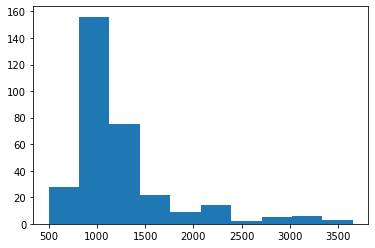

In [73]:
plt.hist(preds)
plt.show()

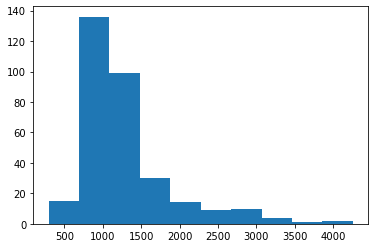

In [66]:
plt.hist(preds_full)
plt.show()

In [54]:
preds = reg.predict(df_test) # No taxi id, origin call, origin stand, no coords
df_pred = pd.read_csv("../data/sampleSubmission.csv")
df_pred["TRAVEL_TIME"] = preds
df_pred.to_csv("./combined_xgboost_all_5_default_15kmax_TRIG.csv", index=False)

In [108]:
# E V E R Y T H I N G
pred = reg.predict(valid[valid["A"] == 1])
print(f"RMSE: {np.sqrt(np.sum((pred - valid_label[valid['A'] == 1])**2) / len(valid[valid['A'] == 1]))}")
pred = reg.predict(valid[valid["B"] == 1])
print(f"RMSE: {np.sqrt(np.sum((pred - valid_label[valid['B'] == 1])**2) / len(valid[valid['B'] == 1]))}")
pred = reg.predict(valid[valid["C"] == 1])
print(f"RMSE: {np.sqrt(np.sum((pred - valid_label[valid['C'] == 1])**2) / len(valid[valid['C'] == 1]))}")

RMSE: 531.4848147987065
RMSE: 464.3774480486925
RMSE: 837.7974275920382


In [8]:
# Yes taxi id, origin call, origin stand, no coords
pred = reg.predict(valid[valid["A"] == 1])
print(f"RMSE: {np.sqrt(np.sum((pred - valid_label[valid['A'] == 1])**2) / len(valid[valid['A'] == 1]))}")
pred = reg.predict(valid[valid["B"] == 1])
print(f"RMSE: {np.sqrt(np.sum((pred - valid_label[valid['B'] == 1])**2) / len(valid[valid['B'] == 1]))}")
pred = reg.predict(valid[valid["C"] == 1])
print(f"RMSE: {np.sqrt(np.sum((pred - valid_label[valid['C'] == 1])**2) / len(valid[valid['C'] == 1]))}")

RMSE: 477.84808351169596
RMSE: 428.91400283658095
RMSE: 786.1901650206082


In [29]:
# simple
pred = reg.predict(valid[valid["A"] == 1])
print(f"RMSE: {np.sqrt(np.sum((pred - valid_label[valid['A'] == 1])**2) / len(valid[valid['A'] == 1]))}")
pred = reg.predict(valid[valid["B"] == 1])
print(f"RMSE: {np.sqrt(np.sum((pred - valid_label[valid['B'] == 1])**2) / len(valid[valid['B'] == 1]))}")
pred = reg.predict(valid[valid["C"] == 1])
print(f"RMSE: {np.sqrt(np.sum((pred - valid_label[valid['C'] == 1])**2) / len(valid[valid['C'] == 1]))}")

RMSE: 534.2977151110199
RMSE: 463.64833608675974
RMSE: 827.8829632643224


## Create prediction csv

In [9]:
df_pred["TRAVEL_TIME"] = preds
df_pred.to_csv("./combined_xgboost_4_all_notimecategories.csv", index=False)